In [11]:

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from matminer.datasets import load_dataset
import pandas as pd
import numpy as np
!pip install matminer

# Load the dataset
df = load_dataset("double_perovskites_gap")

# Preprocessing
y = df['gap gllbsc']
df = df.drop(columns=['gap gllbsc'])

# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
numeric_cols = df.select_dtypes(include=np.number).columns

# Handle missing values (fill with mean for numeric, most frequent for categorical)
for col in numeric_cols:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mean())

for col in categorical_cols:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mode()[0])

# One-hot encode categorical features
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_features = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols))

# Combine encoded features with numerical features
X = pd.concat([df[numeric_cols], encoded_df], axis=1)

# Convert to numpy arrays
X = X.to_numpy()
y = y.to_numpy().reshape(-1, 1)

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define the neural network architecture
class Net(nn.Module):
    def __init__(self, layers, activation):
        super(Net, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:
              if activation == 'relu':
                self.layers.append(nn.ReLU())
              elif activation == 'tanh':
                self.layers.append(nn.Tanh())
              elif activation == 'sigmoid':
                self.layers.append(nn.Sigmoid())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Example usage
# Define a list of architectures to compare
architectures = [
    [X.shape[1], 64, 1],
    [X.shape[1], 128, 1],
]
activation_functions = ['relu']
learning_rates = [0.001]

for architecture in architectures:
  for activation_function in activation_functions:
    for learning_rate in learning_rates:
      model = Net(architecture, activation_function)
      criterion = nn.MSELoss()
      optimizer = optim.Adam(model.parameters(), lr=learning_rate)
      epochs = 50
      for epoch in range(epochs):
          optimizer.zero_grad()
          outputs = model(X_train)
          loss = criterion(outputs, y_train)
          loss.backward()
          optimizer.step()

      with torch.no_grad():
          outputs_test = model(X_test)
          val_loss = criterion(outputs_test, y_test)
          print(f'Architecture: {architecture[1:]}, Activation Function: {activation_function}, Learning Rate: {learning_rate}')
          print(f'Validation Loss: {val_loss:.4f}\n')


Architecture: [64, 1], Activation Function: relu, Learning Rate: 0.001
Validation Loss: 26.7540

Architecture: [128, 1], Activation Function: relu, Learning Rate: 0.001
Validation Loss: 27.1226



Architecture: [64, 1], Activation Function: relu, Learning Rate: 0.001
Validation Loss: 29.0074

Architecture: [128, 1], Activation Function: relu, Learning Rate: 0.001
Validation Loss: 23.6018



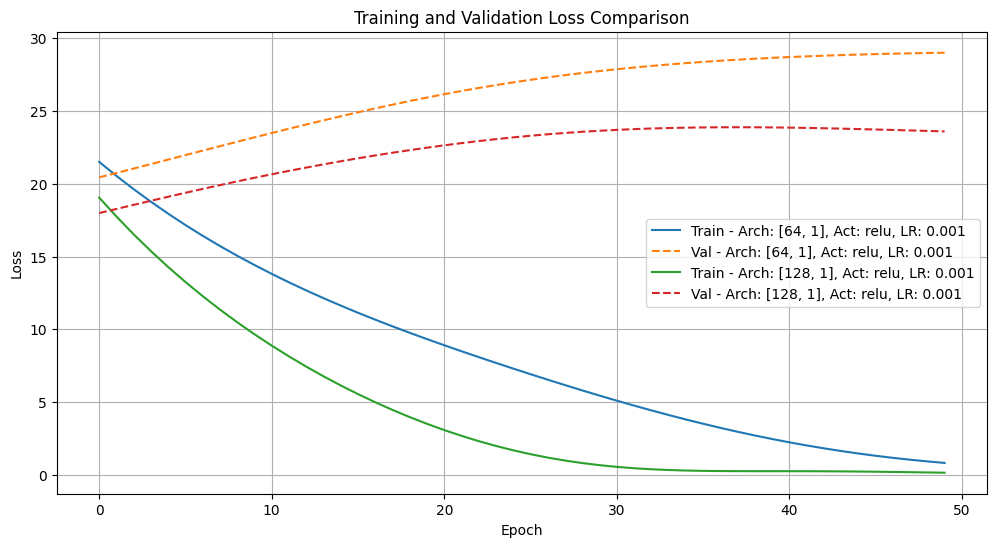

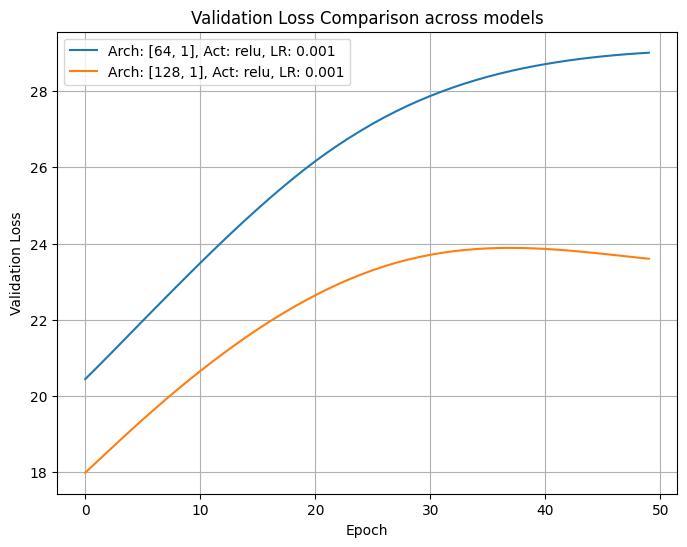

In [14]:
# Store results for plotting
results = []

for architecture in architectures:
  for activation_function in activation_functions:
    for learning_rate in learning_rates:
      model = Net(architecture, activation_function)
      criterion = nn.MSELoss()
      optimizer = optim.Adam(model.parameters(), lr=learning_rate)
      epochs = 50
      train_losses = []
      val_losses = []

      for epoch in range(epochs):
          optimizer.zero_grad()
          outputs = model(X_train)
          loss = criterion(outputs, y_train)
          loss.backward()
          optimizer.step()
          train_losses.append(loss.item())

          with torch.no_grad():
              outputs_test = model(X_test)
              val_loss = criterion(outputs_test, y_test)
              val_losses.append(val_loss.item())

      results.append({
          'architecture': architecture[1:],
          'activation': activation_function,
          'learning_rate': learning_rate,
          'train_losses': train_losses,
          'val_losses': val_losses
      })

      print(f'Architecture: {architecture[1:]}, Activation Function: {activation_function}, Learning Rate: {learning_rate}')
      print(f'Validation Loss: {val_losses[-1]:.4f}\n')


# Plotting
plt.figure(figsize=(12, 6))

for result in results:
    plt.plot(result['train_losses'], label=f"Train - Arch: {result['architecture']}, Act: {result['activation']}, LR: {result['learning_rate']}")
    plt.plot(result['val_losses'], label=f"Val - Arch: {result['architecture']}, Act: {result['activation']}, LR: {result['learning_rate']}", linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Comparison')
plt.legend()
plt.grid(True)
plt.show()


# Comparison plot (Validation Loss)
plt.figure(figsize=(8, 6))
for result in results:
  plt.plot(result['val_losses'], label=f"Arch: {result['architecture']}, Act: {result['activation']}, LR: {result['learning_rate']}")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Comparison across models")
plt.legend()
plt.grid(True)
plt.show()
